In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from datetime import datetime

from qiskit.test.mock import FakeVigo

Running on FakeVigo. We know this works.

In [2]:
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 5 # Total time

TT=T

n = 20

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

In [4]:
device_backend = FakeVigo()

sim_vigo = AerSimulator.from_backend(device_backend) 

#AerSimulator.from_backend : used to create the noise model mimics the real device like ibmq_santiago

#device_backend(Input): one can also get noise model minics Santiago backend using AerSimulator.from_backend(provider.get_backend('ibmq_santiago'))

#sim_vigo (output): one can see it as backend and directly put it on the execute like real device backend.

properties = sim_vigo.properties() # To get info of FakeVigo backend.

In [5]:
shots = 8192

il = [0,1,2,3,4]

#sim_vigo as the backend
Trotter_circuit_sim = execute(Trotter_circuit, sim_vigo, shots=shots, initial_layout=il)

result_sim_noise=Trotter_circuit_sim.result()

In [6]:
Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

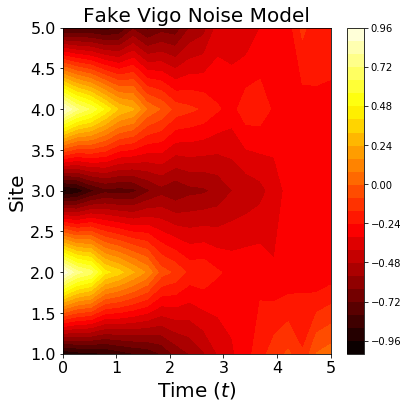

In [7]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Fake Vigo Noise Model', fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

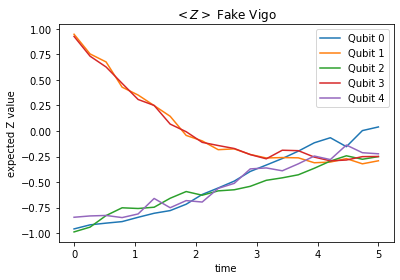

In [8]:
fig,ax = plt.subplots()
ax.plot(t, Sz_sim_noise[:,0], label='Qubit 0')
ax.plot(t, Sz_sim_noise[:,1], label='Qubit 1')
ax.plot(t, Sz_sim_noise[:,2], label='Qubit 2')
ax.plot(t, Sz_sim_noise[:,3], label='Qubit 3')
ax.plot(t, Sz_sim_noise[:,4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$< Z >$ Fake Vigo")
ax.legend()

Here we can see the info about the FakeVigo() backend, such as the error rates, and the most recent update.

In [9]:
from qiskit.tools.jupyter import *
device_backend

<FakeVigo('fake_vigo') from None()>

Now let's try to run the same thing running a different backend:

In [10]:
from qiskit.test.mock import FakeSantiago

In [11]:
device_backend = FakeSantiago()

sim_sant = AerSimulator.from_backend(device_backend)

#AerSimulator.from_backend : used to create the noise model minics the real device like ibmq_santiago

#device_backend(Input): one can also get noise model minics Santiago backend using code AerSimulator.from_backend(provider.get_backend('ibmq_santiago'))

#sim_vigo (output): one can see it as backend and directly put it on the execute like real device backend.

properties = sim_sant.properties() # To get info of FakeSantiago backend.

#noise_model = NoiseModel.from_backend(device_backend)

#coupling_map = device_backend.configuration().coupling_map

#basis_gates = noise_model.basis_gates

In [12]:
Trotter_circuit_sim = execute(Trotter_circuit, sim_sant, shots=shots, initial_layout=il)

result_sim_noise=Trotter_circuit_sim.result()

In [13]:
Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

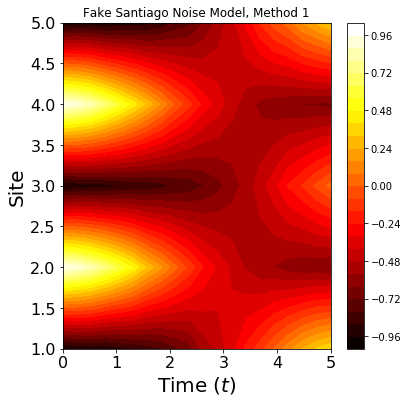

In [14]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Fake Santiago Noise Model, Method 1')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [15]:
from qiskit.tools.jupyter import *
device_backend

<FakeSantiago('fake_santiago') from None()>

This doesn't look right, so we try an alternative method:

In [16]:
from qiskit import IBMQ, Aer

In [19]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

#Trotter_tcircuit = AerSimulator(noise_model=noise_model)

ibmqfactory.load_account:WARNING:2021-06-03 10:18:40,751: Credentials are already in use. The existing account in the session will be replaced.


In [20]:
result = execute(Trotter_tcircuit, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()

AttributeError: 'AerSimulator' object has no attribute 'calibrations'

In [21]:
Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

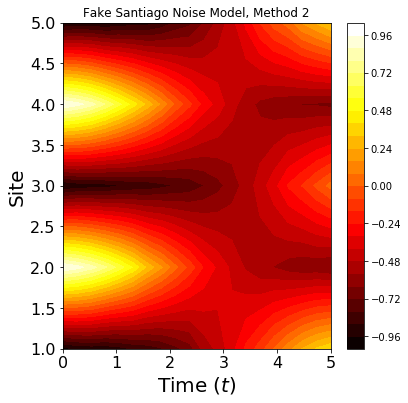

In [22]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Fake Santiago Noise Model, Method 2')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

Cool, so we have that working. Now let's see if we can get this working with an arbitrary backend. We need to check what backends we have simulators for. The code for doing this is in this Youtube video: https://www.youtube.com/watch?v=8xJiUoPYDaY

In [23]:
from qiskit.test.mock import *

In [24]:
from inspect import getmembers, isclass
for member in getmembers(qiskit.test.mock.backends, isclass):
    print(member)

('FakeAlmaden', <class 'qiskit.test.mock.backends.almaden.fake_almaden.FakeAlmaden'>)
('FakeArmonk', <class 'qiskit.test.mock.backends.armonk.fake_armonk.FakeArmonk'>)
('FakeAthens', <class 'qiskit.test.mock.backends.athens.fake_athens.FakeAthens'>)
('FakeBelem', <class 'qiskit.test.mock.backends.belem.fake_belem.FakeBelem'>)
('FakeBoeblingen', <class 'qiskit.test.mock.backends.boeblingen.fake_boeblingen.FakeBoeblingen'>)
('FakeBogota', <class 'qiskit.test.mock.backends.bogota.fake_bogota.FakeBogota'>)
('FakeBurlington', <class 'qiskit.test.mock.backends.burlington.fake_burlington.FakeBurlington'>)
('FakeCambridge', <class 'qiskit.test.mock.backends.cambridge.fake_cambridge.FakeCambridge'>)
('FakeCambridgeAlternativeBasis', <class 'qiskit.test.mock.backends.cambridge.fake_cambridge.FakeCambridgeAlternativeBasis'>)
('FakeCasablanca', <class 'qiskit.test.mock.backends.casablanca.fake_casablanca.FakeCasablanca'>)
('FakeEssex', <class 'qiskit.test.mock.backends.essex.fake_essex.FakeEssex'>

In [25]:
device_backend = FakeRome()

sim_arb = AerSimulator.from_backend(device_backend)

#AerSimulator.from_backend : used to create the noise model minics the real device like ibmq_santiago

#device_backend(Input): one can also get noise model minics Santiago backend using code AerSimulator.from_backend(provider.get_backend('ibmq_santiago'))

#sim_vigo (output): one can see it as backend and directly put it on the execute like real device backend.

properties = sim_arb.properties() # To get info of backend.

In [26]:
Trotter_circuit_sim = execute(Trotter_circuit, sim_arb, shots=shots, initial_layout=il)

In [27]:
result_sim_noise=Trotter_circuit_sim.result()

Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

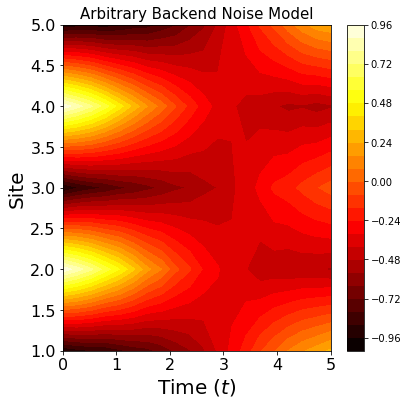

In [28]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Arbitrary Backend Noise Model', fontsize = 15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [29]:
from qiskit.tools.jupyter import *
device_backend

<FakeRome('fake_rome') from None()>